In [ ]:
import tensorflow as tf
import pandas as pd
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import losses
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Exercice 1 Building a neural network to classify texts


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/AI/Data/IMDB Dataset.csv", sep=",")

In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
data['review_length'] = data['review'].apply(lambda x: len(str(x)))
data.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [ ]:
# create graph with number char and +/-

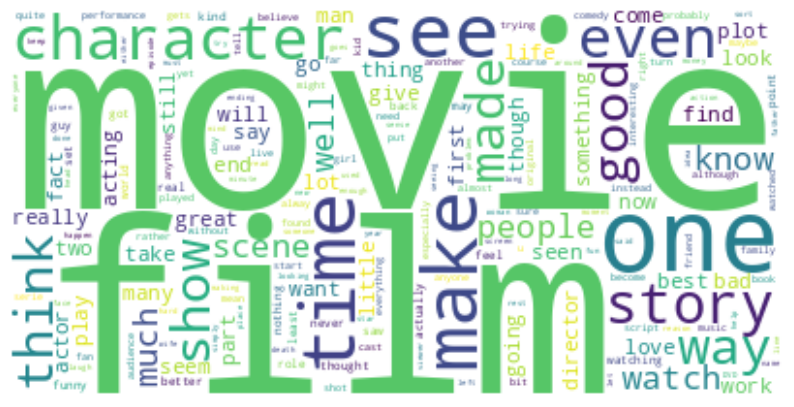

In [ ]:
#WordCloud Visualizations
#Method for creating wordclouds
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def display_cloud(data,color):
    plt.subplots(figsize=(10,10))
    STOPWORDS.add('br')
    wc = WordCloud(stopwords=STOPWORDS,
                   background_color="white", contour_width=2, contour_color=color,
                   max_words=2000, max_font_size=256,
                   random_state=42)
    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

display_cloud(data['review'], 'red')

In [ ]:
english_stops = set(stopwords.words('english'))

def load_dataset():
    df = pd.read_csv("/content/drive/MyDrive/AI/Data/IMDB Dataset.csv", sep=",")
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
25214    [the, feeling, need, someone, play, role, arbi...
18972    [i, impressed, reviews, i, read, film, general...
40069    [what, could, great, film, late, poker, pro, p...
43261    [you, debate, prince, acting, talent, even, ch...
3097     [balance, terror, still, one, best, star, trek...
                               ...                        
27118    [guy, loser, can, get, girls, needs, build, pi...
23118    [i, borrowed, dvd, friend, day, i, really, kno...
8778     [i, obsessed, the, story, amazing, show, highl...
49469    [sure, slasher, films, worth, thecelluloid, fi...
38321    [i, first, see, film, almost, years, ago, itv,...
Name: review, Length: 40000, dtype: object 

11114    [this, show, succeed, appeals, adults, matter,...
31163    [i, enjoyed, longstreet, followed, steps, raym...
24750    [at, point, time, the, lady, shanghai, made, m...
30157    [the, film, begins, people, earth, discovering...
49518    [this, film, left, breathless, wanting, learn,...
 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Tokenize and sequence the reviews
max_words = 10000
max_length = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>') # Out Of Vocab token : https://www.kaggle.com/code/hamishdickson/using-keras-oov-tokens
tokenizer.fit_on_texts(x_data)
sequences = tokenizer.texts_to_sequences(x_data)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='post')

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y_data, test_size=0.2)

# Define the MLP model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, 16, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # explique la ligne

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
1000/1000 [==============================] - 89s 81ms/step - loss: 0.3942 - accuracy: 0.8034 - val_loss: 0.2842 - val_accuracy: 0.8816
Epoch 2/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1673 - accuracy: 0.9390 - val_loss: 0.3265 - val_accuracy: 0.8720
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0468 - accuracy: 0.9868 - val_loss: 0.4350 - val_accuracy: 0.8661
Epoch 4/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.5844 - val_accuracy: 0.8575
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6145 - val_accuracy: 0.8679
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 3.6256e-04 - accuracy: 1.0000 - val_loss: 0.6622 - val_accuracy: 0.8675
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 1.6981e-04 - accuracy: 1.0000 - val_loss: 0.7013

Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1280 - accuracy: 0.9615 - val_loss: 0.3958 - val_accuracy: 0.8715
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0146 - accuracy: 0.9966 - val_loss: 0.5713 - val_accuracy: 0.8629
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.6639 - val_accuracy: 0.8674
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 3.1332e-04 - accuracy: 1.0000 - val_loss: 0.7380 - val_accuracy: 0.8694
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 9.2734e-05 - accuracy: 1.0000 - val_loss: 0.8497 - val_accuracy: 0.8687
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 2.5226e-05 - accuracy: 1.0000 - val_loss: 0.9175 - val_accuracy: 0.8688
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1873e-05 - accuracy: 1.0000 - val_loss: 0.9713

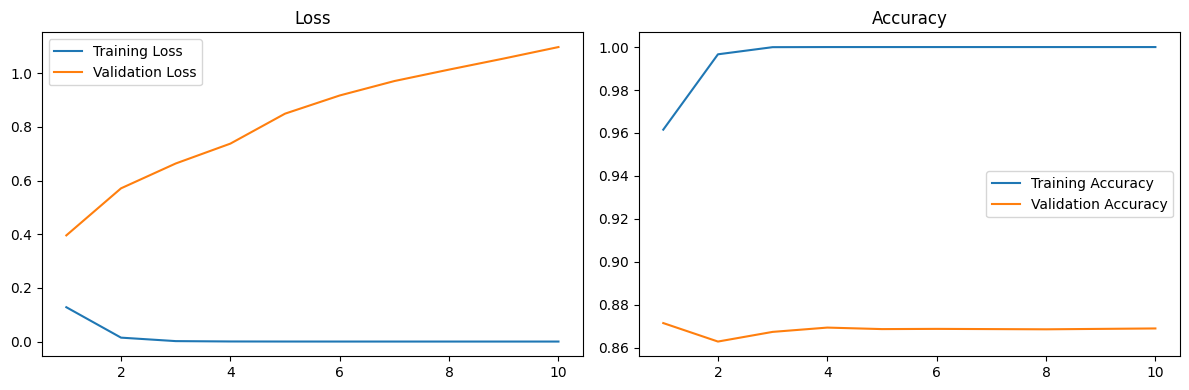

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Plotting the Loss and Accuracy
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()